<a href="https://colab.research.google.com/github/tirthasheshpatel/OOP-in-Python/blob/master/Performance_Review_PyMC3%2C_PyMC4_and_Tensorflow_Probability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%shell
cd /content/

REPONAME="pymc4"
REPO="https://github.com/tirthasheshpatel/pymc4.git"
BRANCH="add-mean"
FILES=`ls -la`
FLAG=0

for file in $FILES
do
    if [[ $file == $REPONAME ]]
    then
        cd $REPONAME
        git stash push
        git checkout $BRANCH
        git pull origin $BRANCH
        git stash pop
        FLAG=1
        break
    fi
done

if [[ $FLAG -eq 0 ]]
then
    git clone $REPO
    cd $REPONAME
    git checkout $BRANCH
fi

pip install -r requirements.txt
pip install -r requirements-dev.txt
pip install --upgrade pymc3
pip install arviz

No local changes to save
Already on 'add-mean'
Your branch is up to date with 'origin/add-mean'.
From https://github.com/tirthasheshpatel/pymc4
 * branch            add-mean   -> FETCH_HEAD
Already up to date.
No stash entries found.
Requirement already up-to-date: pymc3 in /usr/local/lib/python3.6/dist-packages (3.8)


In [2]:
%tensorflow_version 2.x
%cd /content/pymc4
import time
import numpy as np
import theano
import theano.tensor as tt
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability.python.math.psd_kernels import *
import matplotlib.pyplot as plt
import pymc4 as pm4
from pymc4.plots import plot_gp_dist
import pymc3 as pm3
import arviz as az
tfd = tfp.distributions
print(pm3.__version__)
gpu_device = tf.test.gpu_device_name()
print(gpu_device)

/content/pymc4
3.8
/device:GPU:0


## A note on Benchmarking Mean Functions

We don't benchmark mean functions here as the time to compute with GPs is dominated by covariance functions/kernels and during samping. 

## Benchmarking Covariance functions

PyMC4's covariance function/kernels are build mostly upon Tensorflow Probability and performance matches without almost no overhead.

PyMC3's performance is still almost always better than tensorflow or PyMC4 but it fails to work with arbitarily shaped tensors. Though, it's possible to work with minibatches using the `Data` API PyMC3 provides. With TensorFlow Probability and PyMC4, you can directly work with minibatches and vectorize your computations over all the batches making the computations faster.

Let's first look at time taken by PyMC3, PyMC4 and TensorFlow Probability on evaluating a Exponential Quadratic Kernel on a dummy dataset of shape `(2000, 20)`.



In [0]:
# Comparing Exponentiated Quadratic kernel on a data of shape (2000, 20)
data = np.random.randn(2000, 20).astype(np.float32)

In [0]:
# TensorFlow Probability's kernel
tfpk = ExponentiatedQuadratic(1., 1., 1)
# PyMC4's kernel
pm4k = pm4.gp.cov.ExpQuad(1., 1., 1, ARD=False)
# PyMC3's kernel
pm3k = pm3.gp.cov.ExpQuad(1, 1.)

In [5]:
%timeit tfpk.matrix(data, data)

The slowest run took 64.74 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 4.07 ms per loop


In [6]:
%timeit pm4k(data, data)

100 loops, best of 3: 4.08 ms per loop


In [7]:
pm3k_compiled = theano.function([], pm3k(data))
%timeit pm3k_compiled()

100 loops, best of 3: 2.08 ms per loop


Now, let's introduce multiple feature dimensions and compare the performance. As PyMC3 doesn't have a interface to do that, we compare PyMC4 and Tnesorflow Probability here.

In [0]:
data = np.random.randn(2000, 5, 4).astype(np.float32)

In [0]:
# TensorFlow Probability's kernel
tfpk = ExponentiatedQuadratic(1., 1., 2)
# PyMC4's kernel
pm4k = pm4.gp.cov.ExpQuad(1., 1., 2, ARD=False)

In [10]:
%timeit tfpk.matrix(data, data)

100 loops, best of 3: 4.02 ms per loop


In [11]:
%timeit pm4k(data, data)

100 loops, best of 3: 4.07 ms per loop


## Benchmarking GP Sampling using NUTS

As PyMC4 doesn't support samplers other than NUTS, I only benchmark sampling with NUTS. It may be possible to get a better performance using other samplers with different initialization in both PyMC3 and Tensorflow Probability.

The results are kind of a tie between PyMC4 and PyMC3 in terms of comutation. Both take about the same time to sample posterior and posterior predicitive on non-trivial examples. One notable result is that PyMC3 works way better with small data and produces better and less noisy samples that PyMC4 and Tensorflow Probability. I suspect, this is because PyMC3 is very old and has a very advanced sampler design.

### Example 1: Student's T Regression using Latent GP

Let's build a dummy data with 100 examples and 1 feature dimension and then fit a Latant GP model from PyMC3 to a complex function derived from that data. Such examples are commonly seen in many practical settings dealing with small to medium sized data and samplers like NUTS tend to outperform doring inference to successfully quantify uncertainty and provide unbiased estimates from the underlying distribution.

Let's look at how good and fast PyMC3 performs on such a dataset.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: covariance is not positive-semidefinite.


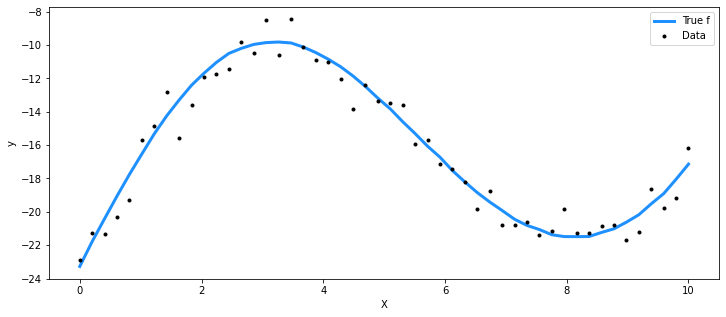

In [12]:
# set the seed
np.random.seed(42)

n = 50 # The number of data points
X = np.linspace(0, 10, n, dtype='float32')[:, None] # The inputs to the GP, they must be arranged as a column vector
n_new = 200
X_new = np.linspace(-5, 15, n_new, dtype='float32')[:,None]

# Define the true covariance function and its parameters
ℓ_true = 5.0
η_true = 36.6
cov_func = pm4.gp.cov.ExpQuad(amplitude=η_true, length_scale=ℓ_true, feature_ndims=1)

# A mean function that is zero everywhere
mean_func = pm4.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
f_true = np.random.multivariate_normal(mean_func(X).numpy(), 
                                       cov_func(X, X).numpy() + 1e-6*np.eye(n), 1).flatten()

# The observed data is the latent function plus a small amount of T distributed noise
# The degrees of freedom is `nu`
ν_true = 10.0
σ_true = 1.0
y = f_true + σ_true * np.random.standard_t(ν_true, size=n)

## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="True f")
ax.plot(X, y, 'ok', ms=3, label="Data")
ax.set_xlabel("X"); ax.set_ylabel("y"); plt.legend();

In [13]:
with pm3.Model() as model:
    ℓ = pm3.Gamma("ℓ", alpha=2, beta=1)
    η = pm3.HalfCauchy("η", beta=5)

    cov = η**2 * pm3.gp.cov.ExpQuad(1, ℓ)
    gp = pm3.gp.Latent(cov_func=cov)

    f = gp.prior("f", X=X)

    σ = pm3.HalfCauchy("σ", beta=5)
    ν = pm3.Gamma("ν", alpha=2, beta=0.1)
    y_ = pm3.StudentT("y", mu=f, lam=1.0/σ, nu=ν, observed=y)

    trace = pm3.sample(draws=1000, tune=100, chains=1)

with model:
    f_pred = gp.conditional("f_pred", X_new)

with model:
    ppc = pm3.sample_posterior_predictive(trace, vars=[f_pred], samples=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/usr/local/lib/python3.6/dist-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/usr/local/lib/python3.6/dist-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNIN

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:297: UserWarning: Could not compute log_likelihood, it will be omitted. Check your model object or set log_likelihood=False
  warnings.warn(warn_msg)


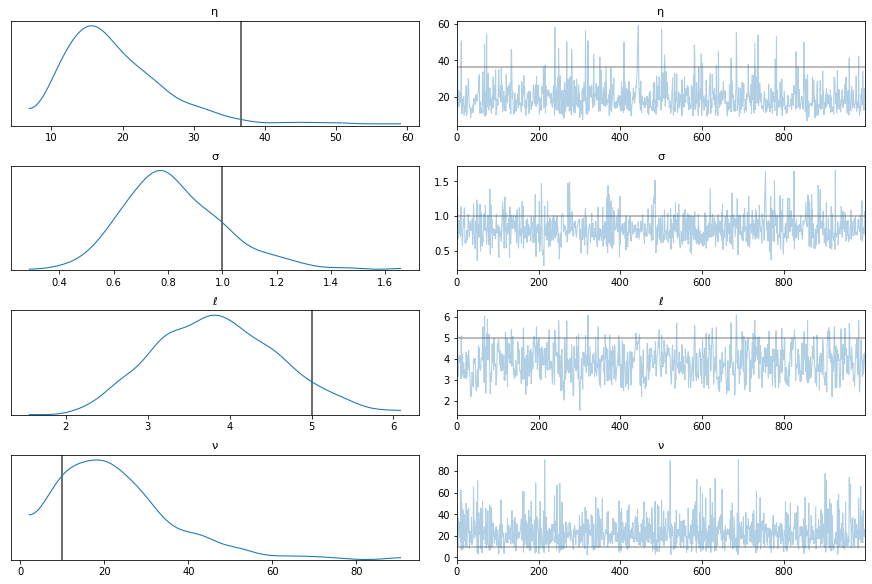

In [14]:
lines = [
    ("η",  {}, η_true), 
    ("σ", {}, σ_true), 
    ("ℓ", {}, ℓ_true),
    ("ν", {}, ν_true),
]
pm3.traceplot(trace, lines=lines, var_names=["η", "σ", "ℓ", "ν"]);

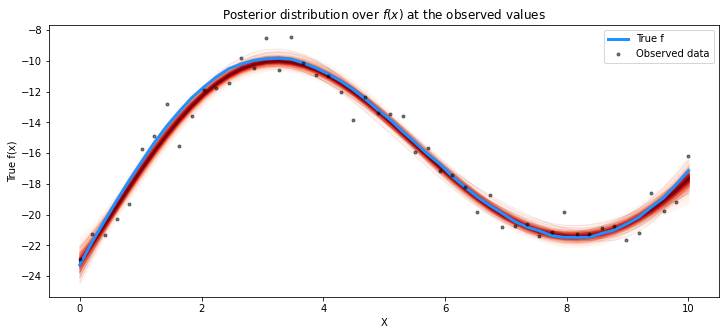

In [15]:
# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, trace["f"], X);

# plot the data and the true latent function
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f");
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");

# axis labels and title
plt.xlabel("X"); plt.ylabel("True f(x)"); 
plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend();

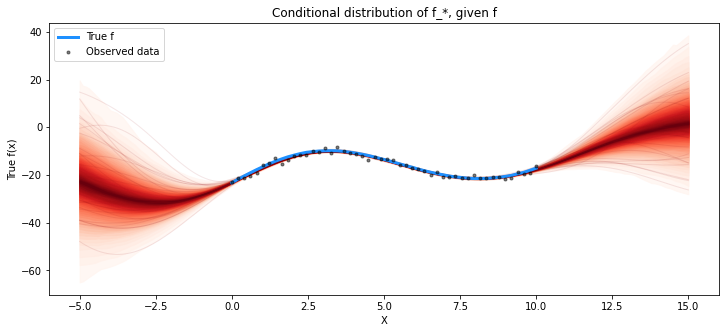

In [16]:
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
plot_gp_dist(ax, ppc["f_pred"], X_new);
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f");
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");
plt.xlabel("X"); plt.ylabel("True f(x)");
plt.title("Conditional distribution of f_*, given f"); plt.legend();

In [0]:
@pm4.model(keep_auxiliary=False, keep_return=False)
def latent_gp_model(X, y, Xnew):
    """
    A latent GP model with unknown length_scale and student-t noise.

    Parameters
    ----------
    X: array_like
        The prior data.
    y: array_like
        The function coressponding to the prior data.
    Xnew: array_like
        The points at which predictions need to be made.
    """
    ℓ           = yield pm4.HalfCauchy("ℓ", scale=3.)
    ν           = yield pm4.Gamma("ν", concentration=1., rate=0.1)
    η           = yield pm4.HalfCauchy("η", scale=5.)
    σ           = yield pm4.HalfCauchy("σ", scale=1./5.)

    cov_fn      = pm4.gp.cov.ExpQuad(length_scale=ℓ, amplitude=η, feature_ndims=1)
    latent_gp   = pm4.gp.LatentGP(cov_fn=cov_fn)

    f           = yield latent_gp.prior("f", X=X)
    f_pred      = yield latent_gp.conditional("f_pred", Xnew, given={'X': X, 'f': f})
    y_pred      = yield pm4.StudentT("y_pred", loc=f, scale=σ, df=ν, observed=y)

In [18]:
with tf.device(gpu_device):
    model = latent_gp_model(X, y, X_new)
    start = time.time()
    trace = pm4.sample(model, num_samples=1000, burn_in=100, num_chains=1, xla=True)
    print(f"Sampling took: {time.time()-start:.4f} seconds")

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Sampling took: 1248.2551 seconds


In [19]:
trace.posterior['latent_gp_model/f_pred']

<xarray.DataArray 'latent_gp_model/f_pred' (chain: 1, draw: 1000, latent_gp_model/f_pred_dim_0: 200)>
array([[[ 0.51438606,  0.50527054,  0.46374536, ..., -0.71397084,
         -0.7079972 , -0.68807745],
        [ 0.6531387 ,  0.6011607 ,  0.57938856, ..., -0.7981542 ,
         -0.7407379 , -0.6844105 ],
        [ 0.2283761 ,  0.36836985,  0.45883167, ..., -0.8523133 ,
         -0.87942255, -0.89916146],
        ...,
        [ 0.45787874,  0.39619112,  0.32981342, ..., -1.0917451 ,
         -1.097932  , -1.1260524 ],
        [ 0.40476486,  0.30979574,  0.18735465, ..., -1.2844942 ,
         -1.3219945 , -1.3542126 ],
        [ 0.26492938,  0.21666875,  0.13716456, ..., -1.3743902 ,
         -1.4333214 , -1.5180495 ]]], dtype=float32)
Coordinates:
  * chain                         (chain) int64 0
  * draw                          (draw) int64 0 1 2 3 4 ... 995 996 997 998 999
  * latent_gp_model/f_pred_dim_0  (latent_gp_model/f_pred_dim_0) int64 0 ... 199

In [0]:
with tf.device(gpu_device):
    ppc = pm4.sample_posterior_predictive(model, trace, var_names=["latent_gp_model/f_pred"])

In [21]:
ppc.posterior

<xarray.Dataset>
Dimensions:                       (chain: 1, draw: 1000, latent_gp_model/f_dim_0: 50, latent_gp_model/f_pred_dim_0: 200)
Coordinates:
  * chain                         (chain) int64 0
  * draw                          (draw) int64 0 1 2 3 4 ... 995 996 997 998 999
  * latent_gp_model/f_dim_0       (latent_gp_model/f_dim_0) int64 0 1 ... 48 49
  * latent_gp_model/f_pred_dim_0  (latent_gp_model/f_pred_dim_0) int64 0 ... 199
Data variables:
    latent_gp_model/f             (chain, draw, latent_gp_model/f_dim_0) float32 -0.48307583 ... -0.015384694
    latent_gp_model/f_pred        (chain, draw, latent_gp_model/f_pred_dim_0) float32 0.51438606 ... -1.5180495
    latent_gp_model/__log_ℓ       (chain, draw) float32 -0.35060522 ... 0.41452742
    latent_gp_model/__log_ν       (chain, draw) float32 2.9762304 ... 2.8819807
    latent_gp_model/__log_η       (chain, draw) float32 -0.68854827 ... 0.17162016
    latent_gp_model/__log_σ       (chain, draw) float32 2.8385825 ... 2.8028266
    latent_gp_model/ℓ             (chain, draw) float32 0.7042617 ... 1.5136553
    latent_gp_model/ν             (chain, draw) float32 19.61374 ... 17.849592
    latent_gp_model/η             (chain, draw) float32 0.50230473 ... 1.1872269
    latent_gp_model/σ             (chain, draw) float32 17.09152 ... 16.491196
Attributes:
    created_at:     2020-06-14T15:52:04.753167
    arviz_version:  0.8.3

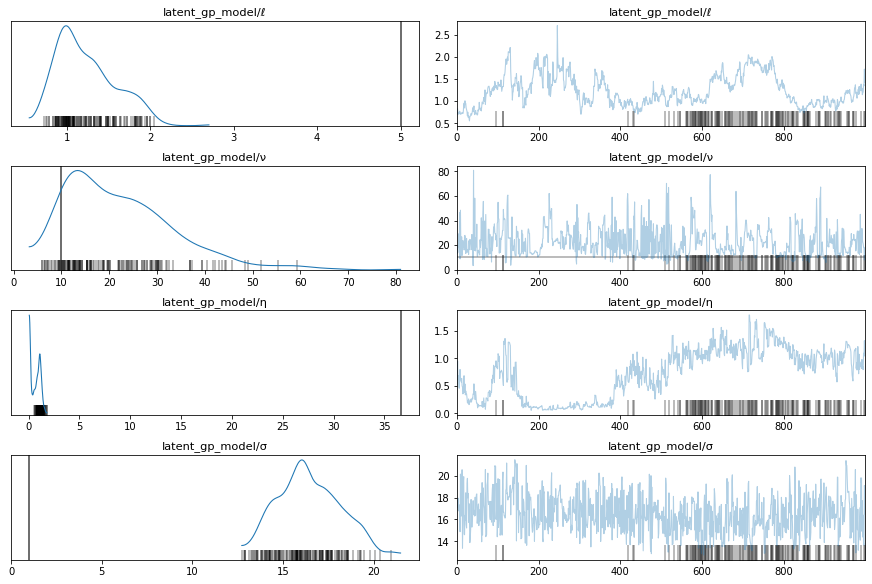

In [22]:
lines = [
    ("latent_gp_model/η",  {}, η_true), 
    ("latent_gp_model/σ", {}, 1.0), 
    ("latent_gp_model/ℓ", {}, ℓ_true),
    ("latent_gp_model/ν", {}, ν_true),
]
az.plot_trace(trace, var_names=["latent_gp_model/ℓ", "latent_gp_model/ν", "latent_gp_model/η", "latent_gp_model/σ"], lines=lines);

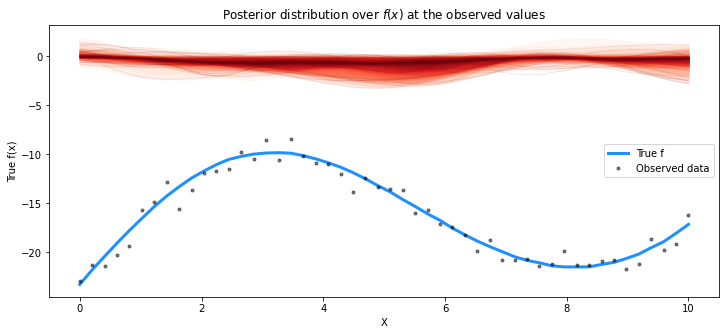

In [23]:
from pymc4.plots import plot_gp_dist

# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
plot_gp_dist(ax, np.array(trace.posterior["latent_gp_model/f"])[0], X)

# plot the data and the true latent function
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f")
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data")

# axis labels and title
plt.xlabel("X"); plt.ylabel("True f(x)")
plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend();

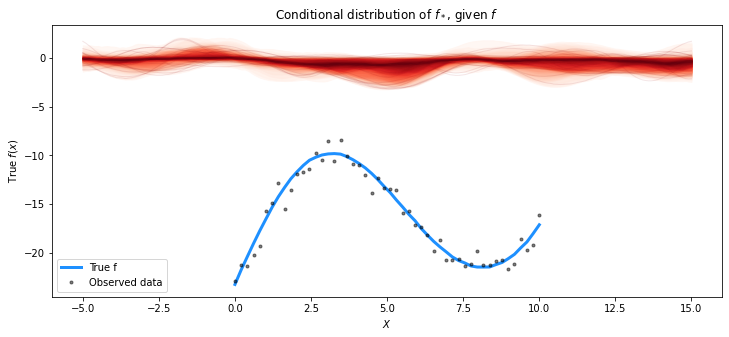

In [24]:
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
plot_gp_dist(ax, ppc.posterior["latent_gp_model/f_pred"][0], X_new)
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f")
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data")
plt.xlabel("$X$"); plt.ylabel("True $f(x)$")
plt.title("Conditional distribution of $f_*$, given $f$"); plt.legend();